In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import struct
import array
import os
from scipy.interpolate import griddata

# Athena++ modules
# import athena_read
import athena_read_select
import h5py
import netCDF4
import xarray as xr

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
filename = 'disk.out1.00100.athdf'

In [3]:
q = 0.9e-3
Rh = (q/3) ** (1/3)

In [4]:
leveln = None
quantities=['rho','press','vel1','vel2','vel3']
with h5py.File(filename, 'r') as f:
      attributes = f.attrs.items()
      attrs = dict(attributes)
      level = f.attrs['MaxLevel']
      time = f.attrs['Time']

subsample = False
if leveln is not None:
    if level > leveln:
        subsample = True
    level = leveln
data = athena_read_select.athdf(filename, quantities=quantities,
    level=level, subsample=subsample)

b'spherical_polar'
[b'prim']
4
[24 24 24]
1480314
2772
[5]
[168  72 576]
[0.4      2.5      1.003814]
[1.3962634 1.7453293 1.       ]
[0.        6.2831855 1.       ]
628.31854
[b'rho' b'press' b'vel1' b'vel2' b'vel3']


In [5]:
data['rho'].shape

(588, 1152, 560)

In [6]:
thetapos=np.abs(data['x2v']-0.5*np.pi).argmin()
phipos=400

In [7]:
r = data['x1v']
theta = data['x2v']
phi = data['x3v']

In [8]:
rp, thetap, phip = 1, np.pi / 2, np.pi

In [9]:
rho = data['rho']

In [10]:
# making r, theta, and phi 3D arrays
r = r[np.newaxis, np.newaxis, :]
theta = theta[np.newaxis, :, np.newaxis]
phi = phi[:, np.newaxis, np.newaxis]

In [11]:
theta.shape

(1, 1152, 1)

In [21]:
x = data['x1v'][np.newaxis, np.newaxis,:] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.cos(data['x3v'][:,np.newaxis, np.newaxis])
y = data['x1v'][np.newaxis, np.newaxis,:] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.sin(data['x3v'][:,np.newaxis, np.newaxis])
z = data['x1v'][np.newaxis, np.newaxis,:] * np.cos(data['x2v'][np.newaxis, :, np.newaxis])

In [13]:
z.shape

(1, 1152, 560)

In [14]:
x.shape

(588, 1152, 560)

In [15]:
# recentering the coordinates to make the planet-centered
r_new = np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi))
phi_new = np.arctan2(r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi) + rp)
theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27391/1201654965.py:4: RuntimeWarning: invalid value encountered in arccos
  theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))


In [16]:
vr = data['vel1']
vtheta = data['vel2']
vphi = data['vel3']

In [17]:
# planet-centered velocities
vr_new = 1 / 2 * 1 / r_new * (2 * r * vr + 2 * rp * (vr * np.sin(theta) * np.cos(phi) + vtheta * np.cos(theta) * np.cos(phi) - vphi*np.sin(phi)))
vtheta_new = r_new * 1 / np.sqrt(r ** 2 * np.sin(theta) ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) \
* ((vtheta * np.sin(theta) - vr * np.cos(theta)) + r * np.cos(theta) / (r ** 2+rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) * \
   (r * vr + vr * rp * np.sin(theta) * np.cos(phi) + rp * vtheta * np.cos(theta) * np.cos(phi) - rp * vphi * np.sin(phi)))
vphi_new = r_new * np.sin(theta_new) * 1 / (r ** 2 * np.sin(theta) ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) * \
(vphi + rp * (vr * np.sin(theta) * np.sin(phi) + vtheta * np.cos(theta) * np.sin(phi) + vphi * np.cos(phi)))

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27391/894961704.py:3: RuntimeWarning: divide by zero encountered in divide
  vtheta_new = r_new * 1 / np.sqrt(r ** 2 * np.sin(theta) ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)) \


In [42]:
lz = (vphi_new + r_new * np.cos(theta)) * r_new * np.cos(theta)

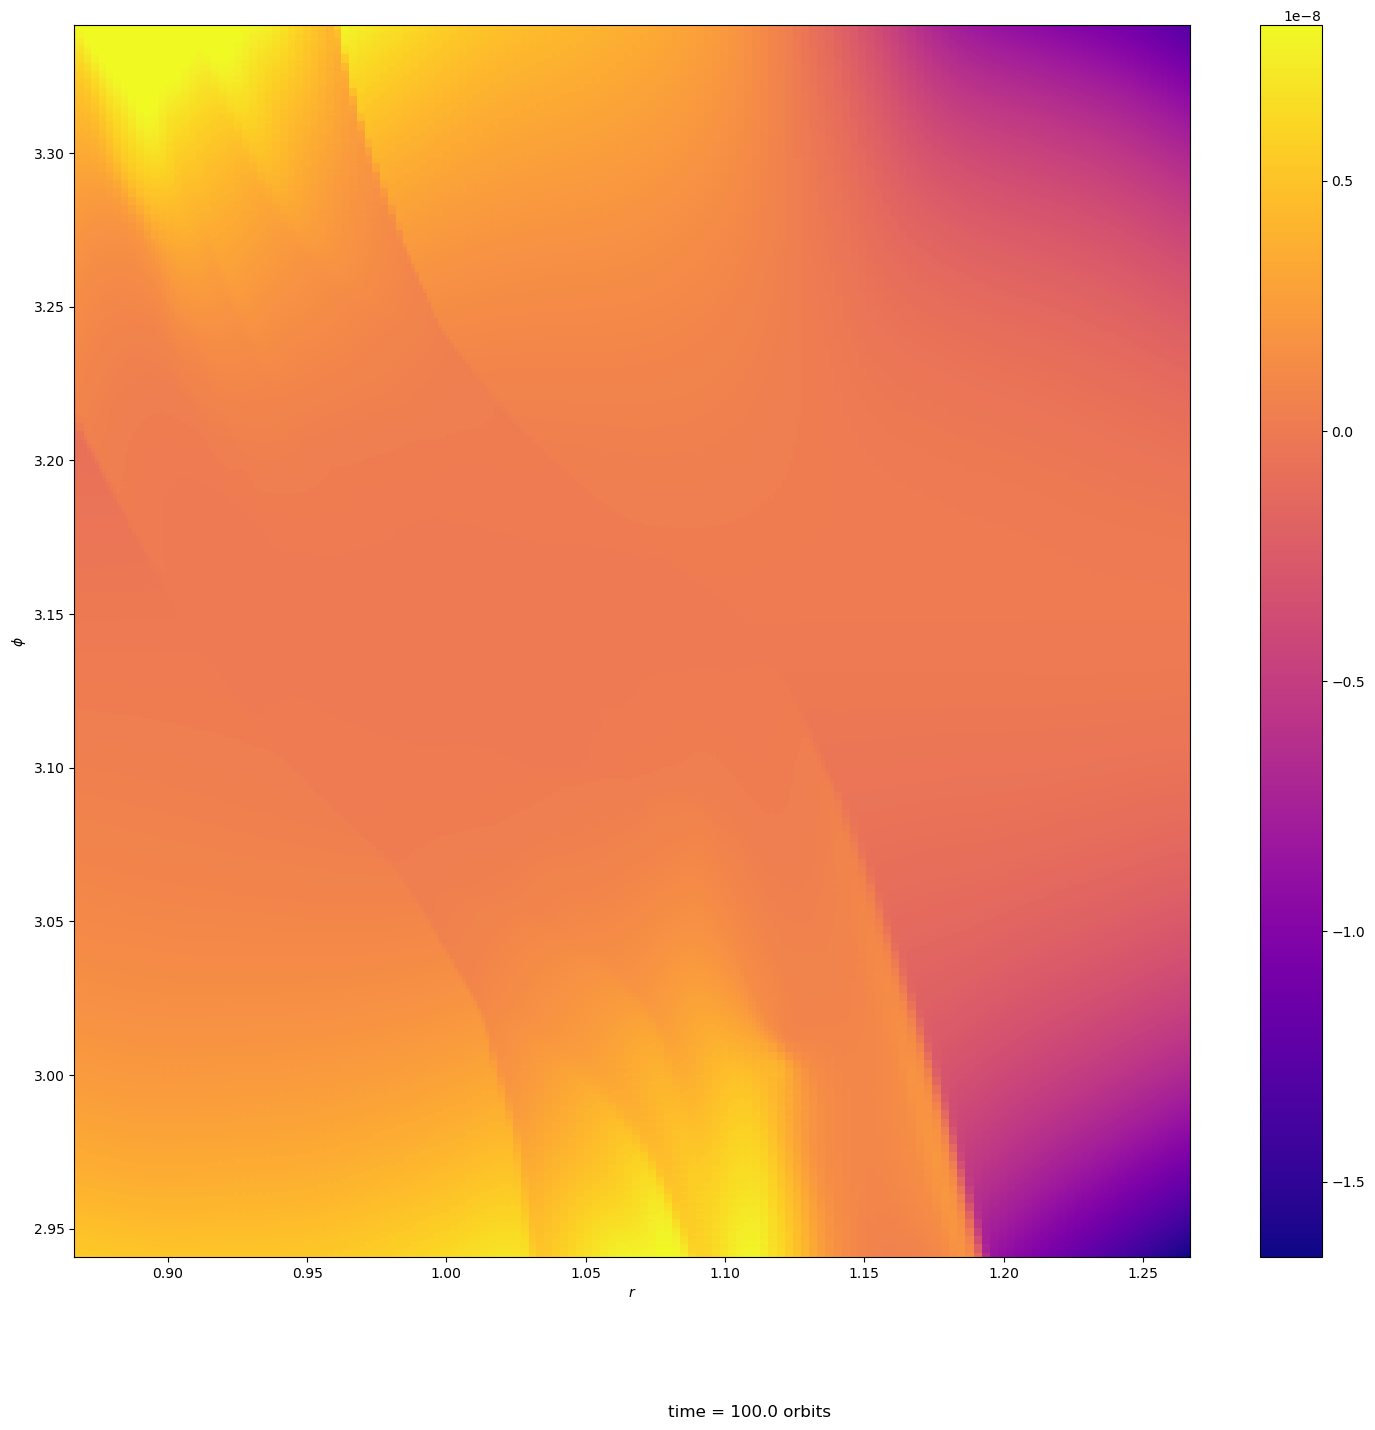

In [43]:
import matplotlib
plots, axes = plt.subplots(figsize=(18,16))

plt.ylabel('$\\phi$')
plt.xlabel('$ r$')
minval=min(lz[:,thetapos,:][0])
maxval=max(lz[:,thetapos,:][0])
ridx = np.where(data['x1f'])[0][:-1]
phiidx = np.where(data['x3f'])[0][:-1]

norm=matplotlib.colors.Normalize(vmin=minval,vmax=maxval)
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x3f'][phiidx])
im=axes.pcolormesh(xmesh,zmesh,lz[:,thetapos,:][phiidx][:,ridx],cmap='plasma', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [22]:
dist = np.sqrt((x + 1) ** 2 + y ** 2 + z ** 2) - Rh

In [23]:
np.unravel_index(np.argmin(dist), dist.shape)

(293, 576, 194)

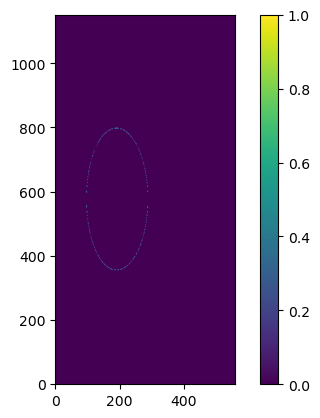

In [24]:
plt.imshow(np.abs(dist[293])<0.0001, origin='lower')
plt.colorbar()

In [25]:
indices = np.nonzero(np.abs(dist)<3e-4)

In [26]:
indices

(array([195, 195, 195, ..., 392, 392, 392]),
 array([562, 562, 562, ..., 589, 589, 589]),
 array([189, 190, 191, ..., 190, 191, 192]))

In [27]:
theta.shape

(1, 1152, 1)

In [28]:
lon = np.pi - phi_new[indices] % (2*np.pi)
lat = np.pi/2 - theta_new[indices] % np.pi

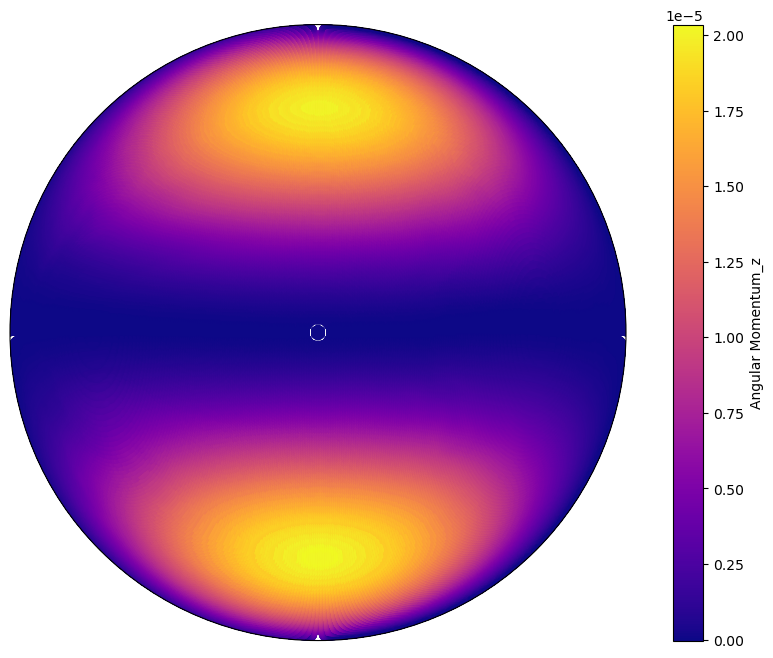

In [44]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='lambert')
cax = ax.scatter(lon, lat, c=lz[indices], s=10, cmap='plasma')
# ax.grid(True)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Angular Momentum_z')
plt.show()

In [30]:
x_new = r_new * np.sin(theta_new) * np.cos(phi_new)
y_new = r_new * np.sin(theta_new) * np.sin(phi_new)
z_new = r_new * np.cos(theta_new)

In [31]:
x_new.shape

(588, 1152, 560)

In [32]:
xp = -1-Rh
yp = 0
zp = 0

In [33]:
dist = np.sqrt((x_new - xp) ** 2 + (y_new - yp) ** 2 + (z_new - zp) ** 2)

In [34]:
vx_new = vr_new * np.sin(theta_new) * np.cos(phi_new) + vtheta_new * np.cos(theta_new) * np.cos(phi_new) - vphi_new * np.sin(phi_new)

vy_new = vr_new * np.sin(theta_new) * np.sin(phi_new) + vtheta_new * np.cos(theta_new) * np.sin(phi_new) + vphi_new * np.cos(phi_new)

vz_new = vr_new * np.cos(theta_new) - vtheta_new * np.sin(theta_new)

lz_new = (vy_new * x_new - vx_new * y_new)
ly_new = (vz_new * x_new - vx_new * z_new)
lx_new = (vz_new * y_new - vy_new * z_new)
Flux_L = (lz_new * vx_new * (x_new - xp) 
                + lz_new * vy_new * (y - yp) 
                + lz_new * vz_new * (z - zp)) / dist

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27391/509065480.py:7: RuntimeWarning: invalid value encountered in subtract
  lz_new = (vy_new * x_new - vx_new * y_new)


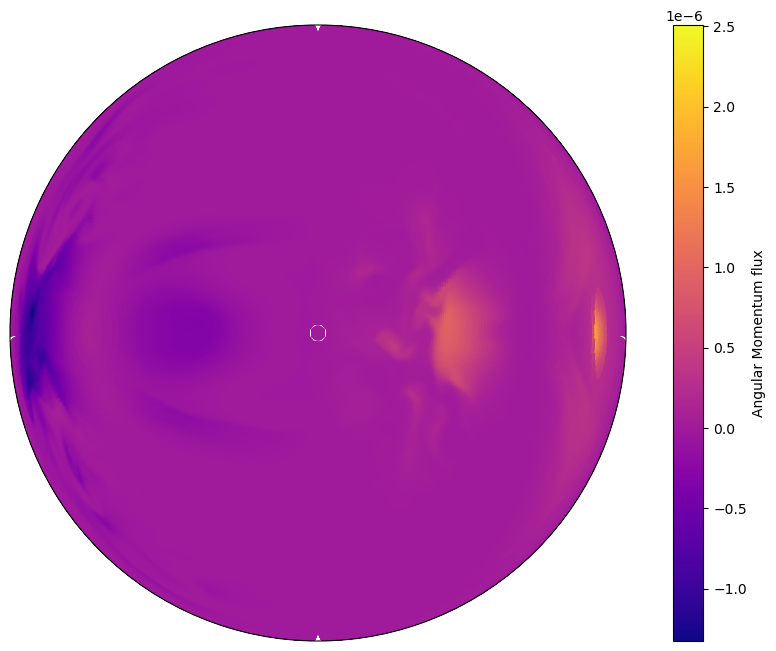

In [36]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='lambert')
cax = ax.scatter(lon, lat, c=Flux_L[indices], s=10, cmap='plasma')
# ax.grid(True)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Angular Momentum flux')
plt.show()

In [37]:
norm_Flux_l = Flux_L / ((- vr_new * vx_new * (x_new - xp) 
                - vr_new * vy_new * (y_new - yp) 
                - vr_new * vz_new * (z_new - zp)) / dist)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27391/1688894280.py:1: RuntimeWarning: invalid value encountered in subtract
  norm_Flux_l = Flux_L / ((- vr_new * vx_new * (x_new - xp)
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27391/1688894280.py:1: RuntimeWarning: divide by zero encountered in divide
  norm_Flux_l = Flux_L / ((- vr_new * vx_new * (x_new - xp)


In [38]:
norm_Flux_l[indices]

array([-0.00132638, -0.00138846, -0.00152143, ..., -0.00071061,
       -0.00067673, -0.00066127], dtype=float32)

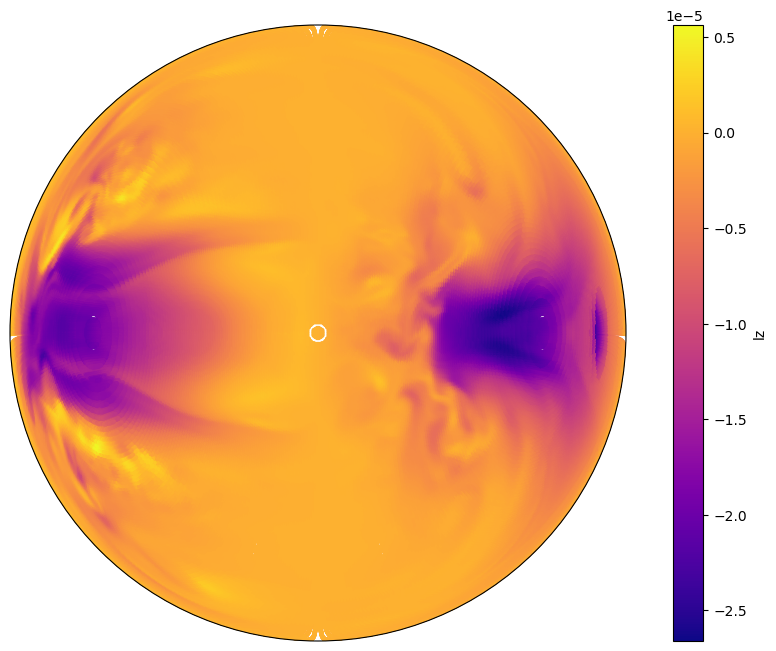

In [41]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='lambert')
cax = ax.scatter(lon, lat, c=lz_new[indices], s=5, cmap='plasma')
# ax.grid(True)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('lz')
plt.show()

In [45]:
# another try 
f = r_new ** 2 * np.sin(theta_new) * (vphi_new * vr_new - vtheta_new * vphi_new)

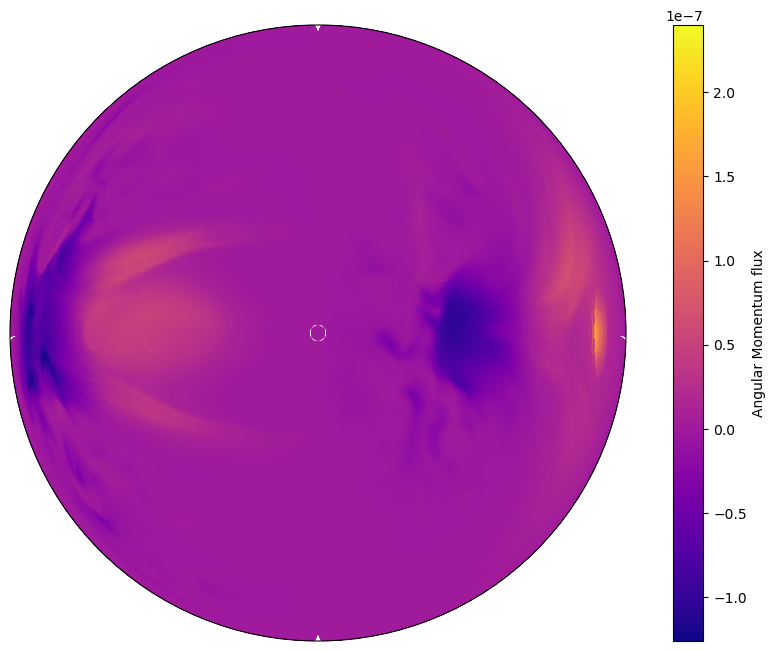

In [46]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='lambert')
cax = ax.scatter(lon, lat, c=f[indices], s=10, cmap='plasma')
# ax.grid(True)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Angular Momentum flux')
plt.show()

In [52]:
R_circ = (2.5 * 0.1 * 1)**(1/3) * (1/0.9e-3)**(1/3) 

In [47]:
C = f / (r_new ** 2 * vr_new * np.sin(theta_new))

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27391/900933597.py:1: RuntimeWarning: divide by zero encountered in divide
  C = f / (r_new ** 2 * vr_new * np.sin(theta_new))
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_27391/900933597.py:1: RuntimeWarning: invalid value encountered in divide
  C = f / (r_new ** 2 * vr_new * np.sin(theta_new))


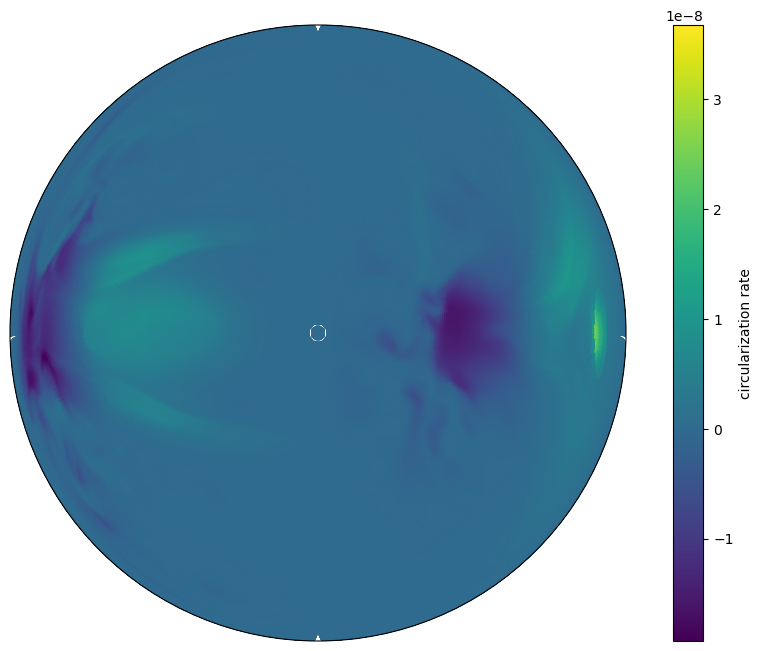

In [53]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='lambert')
cax = ax.scatter(lon, lat, c=f[indices]/R_circ, s=10, cmap='viridis')
# ax.grid(True)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('circularization rate')
plt.show()